In [27]:
import numpy as np
import math
import matplotlib.pyplot as plt
#from time import time

class RBM():
    def __init__(self, n_vis=25, n_hid=10):
        self.n_vis = n_vis
        self.n_hid = n_hid
        # Parameters
        self.W = 0.01 * np.random.randn(n_vis, n_hid)
        self.vbias = np.zeros(n_vis)
        self.hbias =np.zeros(n_hid)
        # Gradients
        self.W_grad = np.zeros(self.W.shape)
        self.vbias_grad = np.zeros(n_vis)
        self.hbias_grad = np.zeros(n_hid)
        # Velocities - for momentum
        self.W_vel = np.zeros(self.W.shape)
        self.vbias_vel = np.zeros(n_vis)
        self.hbias_vel = np.zeros(n_hid)
    
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    
    def h_given_v(self, v):
     
        p = self.sigmoid(np.matmul(v, self.W) + self.hbias)
        return (p, np.random.binomial(1, p=p))
    
    
    def v_given_h(self, h):
   
        p = self.sigmoid(np.matmul(h, self.W.T) + self.vbias)
        return (p, np.random.binomial(1, p=p))
    
    def compute_error_and_grads(self, batch, num_steps=1, method="cd"):

        b_size = batch.shape[0]
        v0 = batch.reshape(b_size, -1)
        
        # Compute gradients - Positive Phase
        ph0, h0 = self.h_given_v(v0)
        W_grad = np.matmul(v0.T, ph0)
        vbias_grad = np.sum(v0, axis=0)
        hbias_grad = np.sum(ph0, axis=0)
        
        # Compute gradients - Negative Phase


        pv1, v1 = self.v_given_h(h0)
        ph1, h1 = self.h_given_v(pv1)
        
        W_grad -= np.matmul(pv1.T, ph1)
        vbias_grad -= np.sum(pv1, axis=0)
        hbias_grad -= np.sum(ph1, axis=0)
        
        self.W_grad = W_grad/b_size
        self.hbias_grad = hbias_grad/b_size
        self.vbias_grad = vbias_grad/b_size
        
        recon_err = np.mean(np.sum((v0 - pv1)**2, axis=1), axis=0) # sum of squared error averaged over the batch
        return recon_err
    
    def update_params(self, lr, momentum=0):
    
        self.W_vel *= momentum
        self.W_vel += (1.-momentum) * lr * self.W_grad
        self.W += self.W_vel
        
        self.vbias_vel *= momentum
        self.vbias_vel += (1.-momentum) * lr * self.vbias_grad
        self.vbias += self.vbias_vel
        
        self.hbias_vel *= momentum
        self.hbias_vel += (1.-momentum) * lr * self.hbias_grad
        self.hbias += self.hbias_vel
        
    def reconstruct(self, v):
        ph0, h0 = self.h_given_v(v)
        pv1, v1 = self.v_given_h(ph0)
        return pv1


In [28]:
# Some parameters to set
batch_size = 10
num_epochs = 300
lr = 0.1
num_steps = 1

In [29]:
def get_batches(data, batch_size, shuffle=False):

    if(shuffle):
        np.random.shuffle(data)
    if(batch_size == -1):
        batch_size = len(data)
    num_batches = math.ceil(data.shape[0]/batch_size)
    for batch_num in range(num_batches):
        yield data[batch_num*batch_size:(batch_num+1)*batch_size]   

In [30]:
#Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# dictionary of data
dct = {'state': {0: [0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0],
                 1: [0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0],
                 2: [0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0],
                 3: [0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0], 
                 4: [0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0], 
                 5: [0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0], 
                 6: [0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0], 
                 7: [0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0],
                 8: [0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0],
                 9: [0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0],
                 10: [0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0],
                 11: [0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0], 
                 12: [0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0], 
                 13: [0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0], 
                 14: [0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0], 
                 15: [0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0],
                 16: [0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0],
                 17: [0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0], 
                 18: [0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0], 
                 19: [0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0],
                 20: [0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0],
                 21: [0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0],
                 22: [0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0],
                 23: [0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0], 
                 24: [0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0], 
                 25: [0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0]},
       'En': {0: 5, 1: 6, 2:5, 3: 9,4: 9, 5: 9,6: 9, 7: 7,8:7,9:10,10:10,11:13,12:5,13:5,14:13,15:10,16:0}}



# forming dataframe
data = pd.DataFrame(dct)

# using to_pickle function to form file
# with name 'pickle_file'
pd.to_pickle(data,'./pickle_file.pkl')

# unpickled the data by using the
# pd.read_pickle method
unpickled_data = pd.read_pickle("./pickle_file.pkl")

data1 = unpickled_data.drop(columns= ['En'])

a=list(data1['state'])

X_train=1.0*np.array(a)


In [31]:
# Our RBM object
rbm = RBM(n_vis=25, n_hid=10)

In [32]:
# Training loop
errors = []

#start_time = time()

for epoch in range(1, num_epochs+1):
    iteration = 0
    error = 0
    for batch in get_batches(X_train, batch_size, shuffle=True):
        iteration += 1
   
        # Compute gradients and errors
        error += rbm.compute_error_and_grads(batch, num_steps=num_steps)
        
        # Update parameters - use momentum as explained in Hinton's guide
        if(epoch > 5):
            rbm.update_params(lr, momentum=0.5)
        else:
            rbm.update_params(lr, momentum=0.9)

    #print("epoch:{} \t error:{:.4f} \t training time:{:.2f} s".format(epoch, error, time()-start_time))
    errors.append(error)



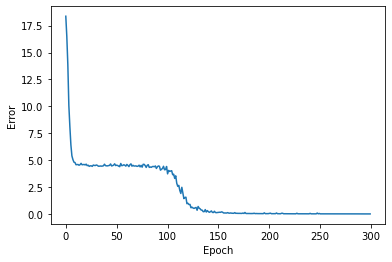

In [33]:
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.plot(errors)
plt.savefig("error_plot")



In [34]:

def plot_images(rbm, images, title='Reconstructed Images', save_as="Reconstructed Images"):
    N=5
    num_samples = len(images)
    plt.clf()
    fig, axes = plt.subplots(2, num_samples, gridspec_kw = {'wspace':0, 'hspace':0.1}, figsize=(2*num_samples, 4))
    fig.suptitle(title)

    for n in range(num_samples):
        axes[0, n].imshow(images[n].reshape(N,N),'gray')
        axes[1, n].imshow(rbm.reconstruct(images[n].reshape(N*N)).reshape(N, N),'gray')
        axes[0, n].axis('off')
        axes[1, n].axis('off')

    plt.savefig(save_as)
    plt.show()
 

In [42]:
#Some hand picked images for each class for plotting

selected_imgs = X_train[[1, 2,3,4,6,7,8,9,10,11,13,14,0, 5,15, 12]]


<Figure size 432x288 with 0 Axes>

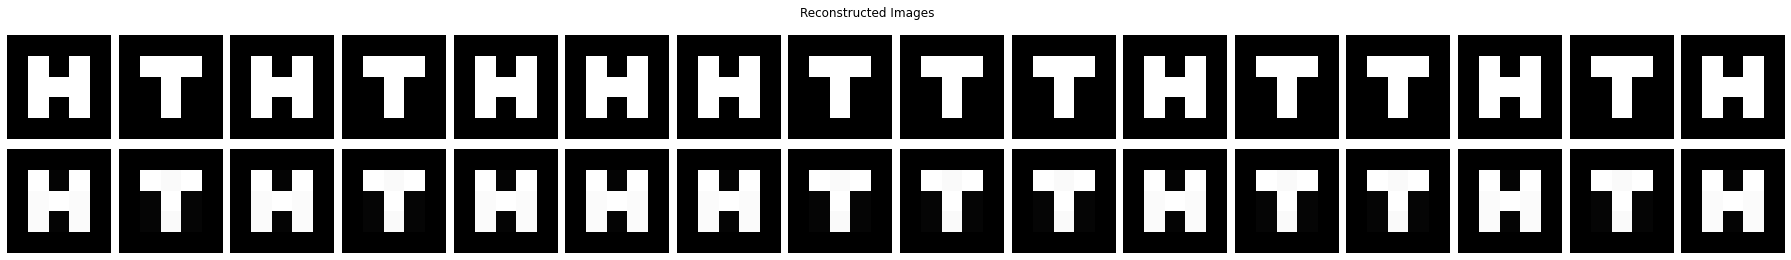

In [36]:
plot_images(rbm, selected_imgs)

In [43]:
from scipy.stats import norm
def plot_weights(rbm):
 
    W_=rbm.W

    plt.hist(W_, density= True)
    mu, std = norm.fit(rbm.W) 
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, linewidth=2)

    plt.show()

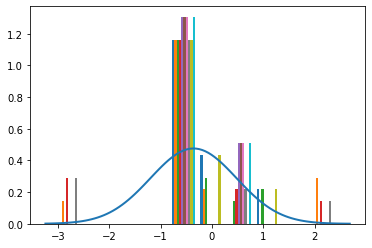

In [44]:
plot_weights(rbm)  

In [39]:
#new data

rand=[[0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0],[0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0]]

In [40]:
selected_rand_imgs = np.array(rand)

<Figure size 432x288 with 0 Axes>

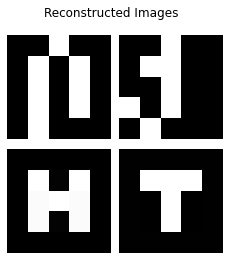

In [41]:
plot_images(rbm, selected_rand_imgs)